# XROMS Vertical Sections

This notebook demonstrates how to set up and examine arbitrary vertical sections
in ROMS' datasets. The section may be quite general, defined by a set of vertices in
grid coordinates ($\xi$, $\eta$). It may be non-straight and/or non-equidistant.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cmocean.cm as cmo
import xroms

## Set up ROMS dataset

More information at in [load_data notebook](load_data.ipynb)

In [2]:
loc = 'http://barataria.tamu.edu:8080/thredds/dodsC/forecast_latest/txla2_his_f_latest.nc'
chunks = {'ocean_time':1}
ds = xr.open_dataset(loc, chunks=chunks)
ds, grid = xroms.roms_dataset(ds)


## Define a section

The plotting notebook shows how to make a horizontal map with cartopy. Using a map 
of the bottom topography, a straight equidistant section approximately normal to the
isobaths is selected by trial and error. 


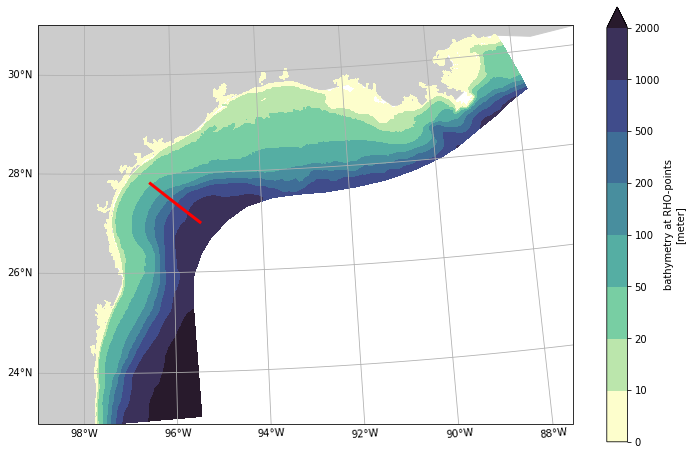

In [3]:
# Map set-up
proj = cartopy.crs.LambertConformal(central_longitude=-98, central_latitude=30)
pc = cartopy.crs.PlateCarree()
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=proj)
ax.set_extent([-99, -87.5, 23, 30.5], crs=pc)
ax.add_feature(cartopy.feature.LAND.with_scale('110m'), facecolor='0.8')
gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, 
                  xlocs=np.arange(-98,-86,2), ylocs=np.arange(24, 32,2))
gl.top_labels = False
gl.right_labels = False

# Add the topography
levels=[0, 10, 20, 50, 100, 200, 500, 1000, 2000]
H = ds.h.where(ds.mask_rho > 0)
H.plot.contourf(ax=ax, x='lon_rho', y='lat_rho', levels=levels, 
                cmap=cmo.deep, transform=pc)

# Add the section
lon = np.linspace(-96.5, -95.4, 101)
lat = np.linspace(27.8, 27.0, 101)
plt.plot(lon, lat, 'r', lw=3, transform=pc);

## Convert to ROMS grid coordinates

A function `ll2xy` converts from lon/lat to ROMS grid coordinates ($\xi$, $\eta$)
using scipy's griddata function. The inverse `xy2ll` is simpler, 
using xarray's interp function.

In [4]:
X, Y = xroms.ll2xy(ds, lon, lat)

## The section dataset

The section function defines an xarray Dataset containing (nearly) all variables from
the ROMS dataset. It is defined on a staggered 2D coordinate system, with 
horizontal dimension `distance` and `s_rho` as vertical coordinates. A xgcm grid is
also returned, useful for generating quantitative data from the section..


In [5]:
# Få bedre navn enn grids
dss, grids = xroms.section(ds.isel(ocean_time=0), X, Y)
dss

<xarray.Dataset>
Dimensions:         (distance: 100, distance_b: 101, s_rho: 30, s_w: 31, tracer: 6)
Coordinates:
  * distance_b      (distance_b) float64 0.0 1.402e+03 ... 1.391e+05 1.405e+05
  * distance        (distance) float64 700.9 2.103e+03 ... 1.384e+05 1.398e+05
  * s_rho           (s_rho) float64 -0.9833 -0.95 -0.9167 ... -0.05 -0.01667
  * s_w             (s_w) float64 -1.0 -0.9667 -0.9333 ... -0.06667 -0.03333 0.0
    lon_rho         (distance) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    lat_rho         (distance) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    ocean_time      datetime64[ns] 2020-08-10T01:00:00
    z_w             (s_w, distance) float64 dask.array<chunksize=(31, 100), meta=np.ndarray>
    z_rho           (s_rho, distance) float64 dask.array<chunksize=(30, 100), meta=np.ndarray>
Dimensions without coordinates: tracer
Data variables:
    ntimes          int32 8640
    ndtfast         int32 40
    dt              float64 40.0
    dtfast          float64 1.0
    dstart          datetime64[ns] 2020-08-10
    shuffle         int32 1
    deflate         int32 1
    deflate_level   int32 1
    nHIS            int32 90
    ndefHIS         int32 0
    nRST            int32 2160
    nSTA            int32 90
    Falpha          float64 2.0
    Fbeta           float64 4.0
    Fgamma          float64 0.284
    nl_tnu2         (tracer) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    nl_visc2        float64 5.0
    LuvSponge       int32 1
    LtracerSponge   (tracer) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    Akt_bak         (tracer) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    Akv_bak         float64 1e-05
    Akk_bak         float64 5e-06
    Akp_bak         float64 5e-06
    rdrg            float64 0.0003
    rdrg2           float64 0.003
    Zob             float64 0.005
    Zos             float64 0.02
    gls_p           float64 -1.0
    gls_m           float64 0.5
    gls_n           float64 -1.0
    gls_cmu0        float64 0.5477
    gls_c1          float64 0.555
    gls_c2          float64 0.833
    gls_c3m         float64 -0.6
    gls_c3p         float64 1.0
    gls_sigk        float64 2.0
    gls_sigp        float64 2.0
    gls_Kmin        float64 1e-09
    gls_Pmin        float64 1e-12
    Charnok_alpha   float64 1.4e+03
    Zos_hsig_alpha  float64 0.5
    sz_alpha        float64 0.25
    CrgBan_cw       float64 100.0
    Znudg           float64 0.0
    M2nudg          float64 1.0
    M3nudg          float64 1.0
    Tnudg           (tracer) float64 dask.array<chunksize=(6,), meta=np.ndarray>
    Tnudg_SSS       float64 0.0
    rho0            float64 1.025e+03
    gamma2          float64 1.0
    LuvSrc          int32 1
    LwSrc           int32 0
    LtracerSrc      (tracer) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    LsshCLM         int32 0
    Lm2CLM          int32 0
    Lm3CLM          int32 1
    LtracerCLM      (tracer) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    LnudgeM2CLM     int32 0
    LnudgeM3CLM     int32 1
    LnudgeTCLM      (tracer) int32 dask.array<chunksize=(6,), meta=np.ndarray>
    spherical       int32 1
    xl              float64 9.969e+36
    el              float64 9.969e+36
    Vtransform      int32 2
    Vstretching     int32 4
    theta_s         float64 5.0
    theta_b         float64 0.4
    Tcline          float64 20.0
    hc              float64 20.0
    grid            int32 1
    Cs_r            (s_rho) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    Cs_w            (s_w) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    h               (distance) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    f               (distance) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    pm              (distance) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    pn              (distance) float64 dask.array<chunksize=(100,), meta=np.ndarray>
    angle           (distance)

## Plot the section

A variable along the section can be plotted by using `z_rho` as vertical coordinate.
Several choices are possible for the horizontal coordinate. The horizontal dimension
`distance` may be the obvious choice.

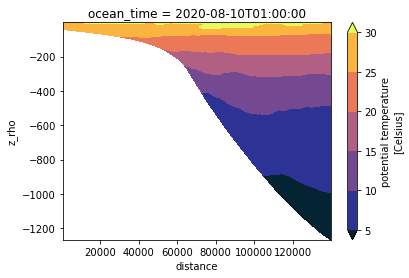

In [6]:
levels = np.arange(5, 35, 5)
dss.temp.plot.contourf('distance', 'z_rho', levels=levels, cmap=cmo.thermal);

## Plotting hydrography

The purpose of this cell is to provide a nicer view of the hydrography along the 
section. We define a new vertical coordinate `depth` which have positive values.
A new horizontal coordinate `dist` provide distance in km, which gives nicer numbers.
Using `long_name` and `units` attributes of the coordinate variables give control ocer
the axis labels.

The depth range is limited to 400 m to show more details in the upper layer.

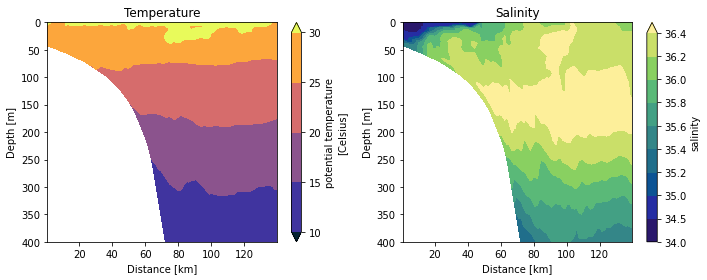

In [7]:
# New coordinates
dss.coords["depth"] = -dss.z_rho
dss.depth.attrs = {'long_name':'Depth', 'units': 'm'}
dss.coords["dist"] = dss.distance * 1e-3
dss.dist.attrs = {'long_name': 'Distance', 'units': 'km'}

# Plot
plt.figure(figsize=(10,4))
# Temperature
plt.subplot(1,2,1)
levels = np.arange(10, 35, 5)
dss.temp.plot.contourf('dist', 'depth', ylim=(400, 0), levels=levels, cmap=cmo.thermal)
plt.title("Temperature")
# Salinity
plt.subplot(1,2,2)
levels = [34, 34.5, 35, 35.2, 35.4, 35.6, 35.8, 36, 36.2, 36.4]
dss.salt.plot.contourf('dist', 'depth', ylim=(400, 0), levels=levels, cmap=cmo.haline)
plt.title("Salinity")

plt.tight_layout()

## Current

The section dataset provide the normal and tangential current along the section.
The sign convention is that tangential current is positive in the direction of increasing distance, and the tangential and normal current is forms a right hand 
system. 

In the plot below, the positive red Gulf stream goes towards northeast. 
On the shelf there is a counterflow towards southwest.

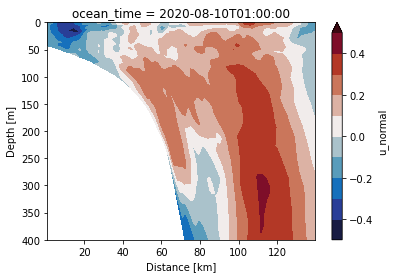

In [8]:
# Choose symmetric speed levels around zero and plot the normal current
levels = np.arange(-0.5, 0.6, 0.1)
dss.u_normal.plot.contourf('dist', 'depth', ylim=(400, 0), levels=levels, cmap=cmo.balance);

## Section metrics

Some geographical characteristics of the section is easily computed.
The `xgcm` Grid object is not essential but simplifies the notation.
The vertical and horisontal axes are noted `Z` and `L` respectively.

Without `xgcm` the mean depth can be calculated as
```python
    mean_depth = np.sum(dss.h * dss.ddistance) / np.sum(dss.ddistance)
```

In [9]:
length = np.sum(dss.ddistance)
mean_depth = grids.average(dss.h, axis='L')
max_depth = dss.h.max()
area = grids.integrate(dss.h, axis='L')   # Undisturbed area

print(f"Length        =  {float(length)*1e-3:.2f} km")
print(f"Mean depth    =  {float(mean_depth):.2f} m")
print(f"Maximum depth = {float(max_depth):.2f} m")
print(f"Area          =   {float(area)*1e-6:.2f} km²")

Length        =  140.52 km
Mean depth    =  534.26 m
Maximum depth = 1356.77 m
Area          =   75.07 km²


## Flux calculations

Integrating quantities based on the normal current gives quantitative
flux estimates. These estimates may depend on the number of points along
the section. 

For more robust flux estimates, a "staircase" section object
following the horizontal grid cell structure in ROMS may be better. This
has the advantage of using ROMS flux values without any interpolation.
This is presently not available in `xroms`.

In [10]:
LZ = ('L', 'Z')
totflux = grids.integrate(dss.u_normal, LZ)
northflux = grids.integrate(dss.u_normal.where(dss.u_normal > 0), LZ)
southflux = -grids.integrate(dss.u_normal.where(dss.u_normal < 0), LZ)

print(f"Net volume flux        = {float(totflux)*1e-6:.1f} Sv")
print(f"Northwards volume flux = {float(northflux)*1e-6:.1f} Sv")
print(f"Southwards volume flux =  {float(southflux)*1e-6:.1f} Sv")


Net volume flux        = 10.1 Sv
Northwards volume flux = 12.6 Sv
Southwards volume flux =  2.5 Sv


## Flux series

Using the total time dependent dataset it is possible to estimate
the time series of flux through the section. With a remote dataset,
this may take some time as data from every time step has to be downloaded
and read into computer memory.

Text(0, 0.5, 'Net volume flux [Sv]')

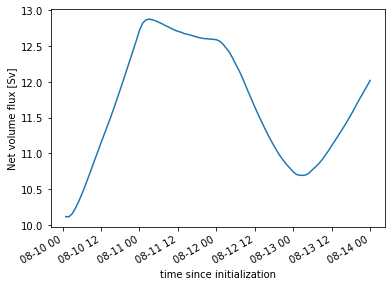

In [12]:
#dss_all_times, grids_all_times = xroms.section(ds, X, Y)
#totflux_series = grids_tot.integrate(dss_all_times.u_normal, LZ) * 1e-6
totflux_series.plot()
plt.xlabel("Time")
plt.ylabel('Net volume flux [Sv]');